In [75]:
""" to looj at spectral power of strokes,
compare different filtering, interpolation and smoothing methods,
and reasoning leading to a standardized methodlogy
ALSO looking at calculation of velocity (differntiation)
"""



' to looj at spectral power of strokes,\ncompare different filtering, interpolation and smoothing methods,\nand reasoning leading to a standardized methodlogy'

In [76]:
%load_ext autoreload
%autoreload 2

%cd ..

from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.preprocess import *
from tools.dayanalysis import *
from analysis.line2 import *

from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/data1/code/python


In [424]:
# animal = "Red"
# expt = "lines2"
# date = 200907
# session = 1
animal = "Pancho"
expt = "lines2"
date = 200907
session = 2

# = [("lines2", "Red", 200907),
#  ("lines2", "Pancho", 200907)]

fd = loadSingleData(animal, date, expt, session, resave_as_dict=False, load_resaved_data=True, 
                          resave_overwrite=False)


found one matching filename: ['/data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.h5']
found one matching filename: ['/data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.pkl']
-- loaded presaved data: /data2/animals/Pancho/200907/200907_152527_lines2_Pancho_2.pkl


## What is spectral content of behavior? (pre processing)

got 1135 total trials
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize


(0, 10000000000.0)

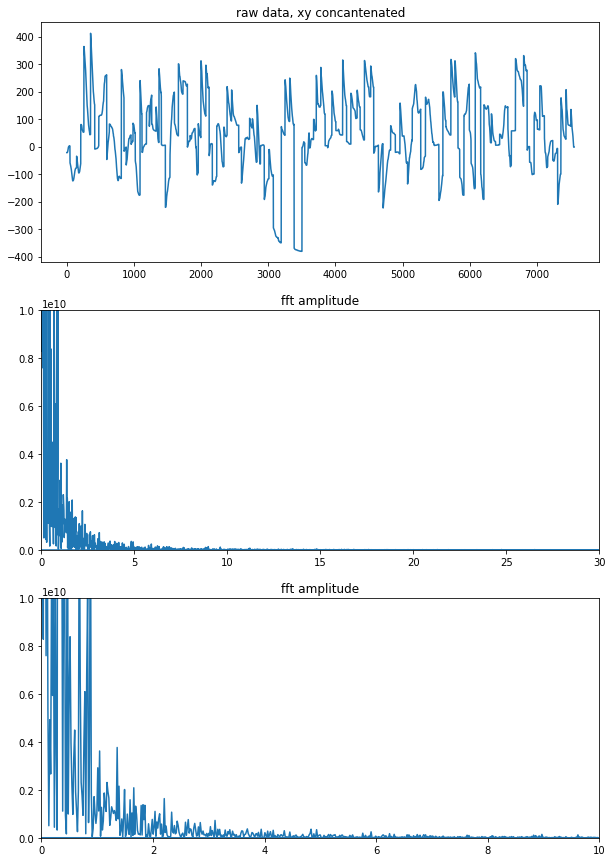

In [242]:
## Get timeseries of behavior, concatenate, and plot spectrum

from numpy import fft

# get 20 random trails.
trials = [t for t in getIndsTrials(fd) if getTrialsFixationSuccess(fd,t)==True]
trials = random.sample(trials, 20) 

# get concatenated beahvior across trials.
# one long vector concatenating x,y and across trials.
strokeslist = []
for t in trials:
    strokes = getTrialsStrokes(fd, t, smooth_window=[], adapt_win_len="adapt", 
                               only_if_part_of_stroke_postgo=True, concat_into_xyt=True)
    strokeslist.append(np.r_[strokes[:,0], strokes[:,1]])
sflat = np.concatenate(strokeslist)
    
# do fft   
f = fft.fft(sflat)
fs = fd["params"]["sample_rate"]
freq = fft.fftfreq(sflat.shape[0], d=1/fs)

# plot
plt.figure(figsize=(10,15))
plt.subplot(311)
plt.title('raw data, xy concantenated')
plt.plot(sflat)

plt.subplot(312)
plt.title('fft amplitude')
# plt.plot(freq, f.real, freq, f.imag)
plt.plot(freq, np.abs(f)**2)
# plt.plot(freq, np.abs(f))
plt.xlim([0, 30])
# plt.semilogy(freq, np.abs(f)**2)
# plt.show()
plt.ylim([0, 1e10])

plt.subplot(313)
plt.title('fft amplitude')
# plt.plot(freq, f.real, freq, f.imag)
plt.plot(freq, np.abs(f)**2)
# plt.plot(freq, np.abs(f))
plt.xlim([0, 10])
plt.ylim([0, 1e10])
# plt.semilogy(freq, np.abs(f)**2)
# plt.show()


## testing sequencing of filtering preprocessing

(-278.25245841378705, 193.10966908007714)

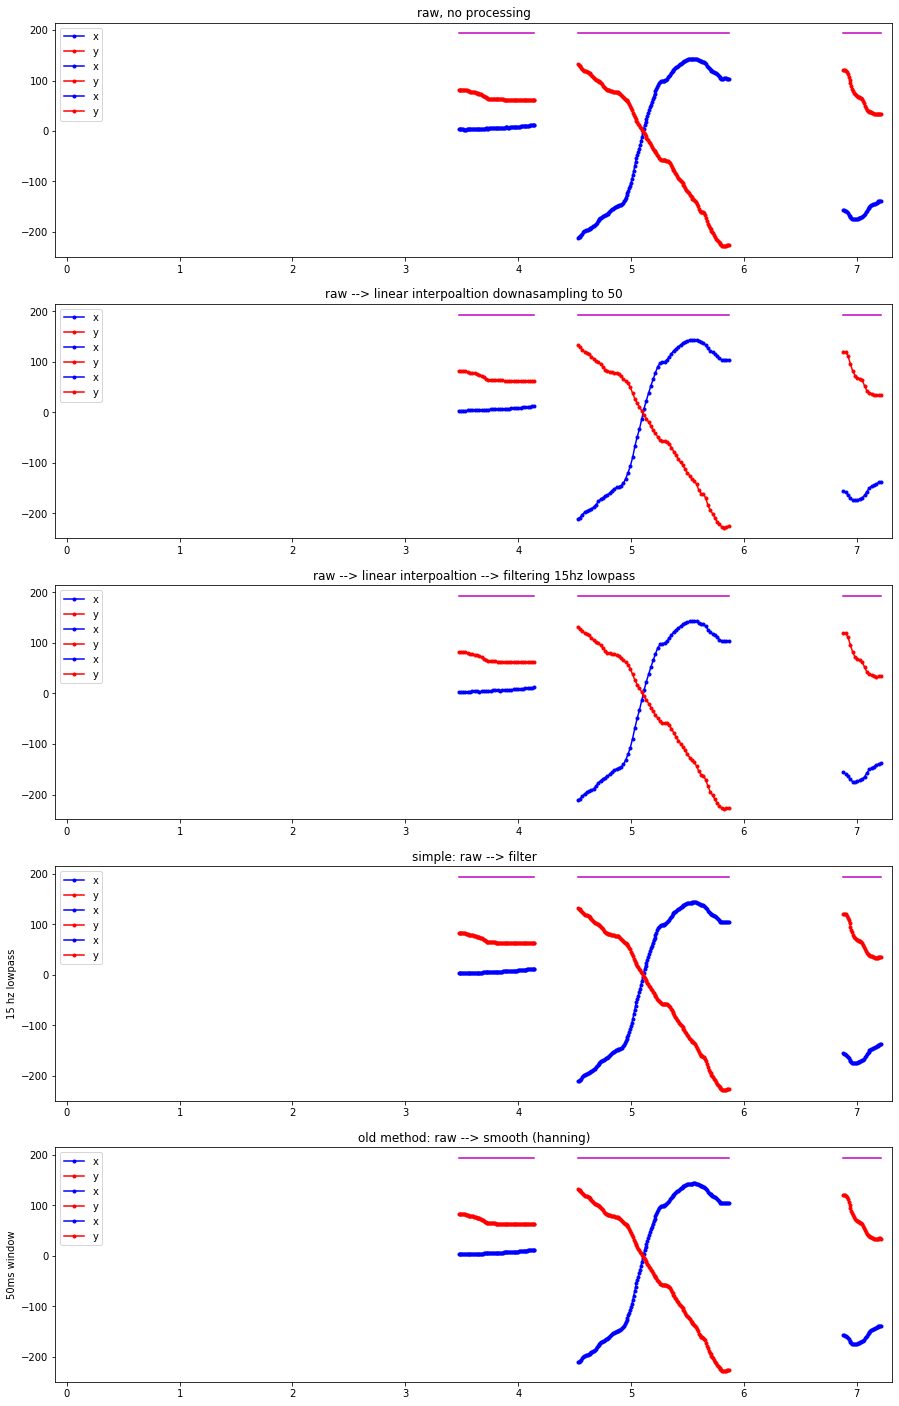

In [243]:
## ==== filtering in frequency domain
%matplotlib inline
from pythonlib.tools.stroketools import strokesInterpolate2, strokesFilter

trial = random.randint(1, fd["params"]["n_trials"])
strokes = getTrialsStrokes(fd, trial,smooth_window=[], adapt_win_len="adapt", 
                           only_if_part_of_stroke_postgo=False)[:]
import copy
strokes_copy = copy.deepcopy(strokes)


if False:
    # if want to purposely test by shorteining strok...
    strokes_copy[0] = strokes_copy[0][:10, :]
    


# strokes = getTrialsStrokesByPeanuts(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"])
fs = fd["params"]["sample_rate"]

plt.figure(figsize=(15,25))
ax = plt.subplot(511)
plotDatStrokesTimecourse(strokes, ax)
plt.title("raw, no processing")
# [print(strok.shape) for strok in strokes]

# 1) Downsample by linear interpolation
fs_new = 50
N = ["fsnew", fs_new, fs]
strokes = strokesInterpolate2(strokes, N=N, kind="linear")
fs = fs_new
ax = plt.subplot(512)
plt.title(f"raw --> linear interpoaltion downasampling to {fs_new}")
plotDatStrokesTimecourse(strokes, ax)
# [print(strok.shape) for strok in strokes]

# 2) Smooth
if True:
    fhi = 15
    strokes = strokesFilter(strokes, [None, fhi], fs=fs, N=3)
    ax = plt.subplot(513)
    plt.title(f"raw --> linear interpoaltion --> filtering {fhi}hz lowpass")
    plotDatStrokesTimecourse(strokes, ax)
#     [print(strok.shape) for strok in strokes]    

# ================= FILTER, WITHOUT FIRST DOWNSAMPLING
# 2) Smooth
fs = fd["params"]["sample_rate"]

fhi = 15
strokes_copy_filt = strokesFilter(strokes_copy, [None, fhi], fs=fs, N=9)
ax = plt.subplot(514)
plt.title("simple: raw --> filter")
plt.ylabel(f"{fhi} hz lowpass")
plotDatStrokesTimecourse(strokes_copy_filt, ax)

strokes_copy_sm = smoothStrokes(strokes_copy, fs)
ax = plt.subplot(515)
plt.ylabel('50ms window')
plt.title("old method: raw --> smooth (hanning)")
plotDatStrokesTimecourse(strokes_copy_sm, ax)



### conclusion:
From above, seems like best to filter raw data directly, no interpolation first.
I previously would smooth raw data, so this is not too different.
Whether or not do interpolation depends on if want to match sample rates to standardized rate..


## velocity
Best sequence of preprocessing for extracting velocity


In [444]:
# ***** 2) Do stuff with the timecourse?

t = random.sample([t for t in getIndsTrials(fd) if getTrialsFixationSuccess(fd, t)], 1)[0]

got 983 total trials


4.795999999999999
0.28320075000004863
4.795999999999999
not enough data to filter - using smoothing instead, and adaptive windowsize


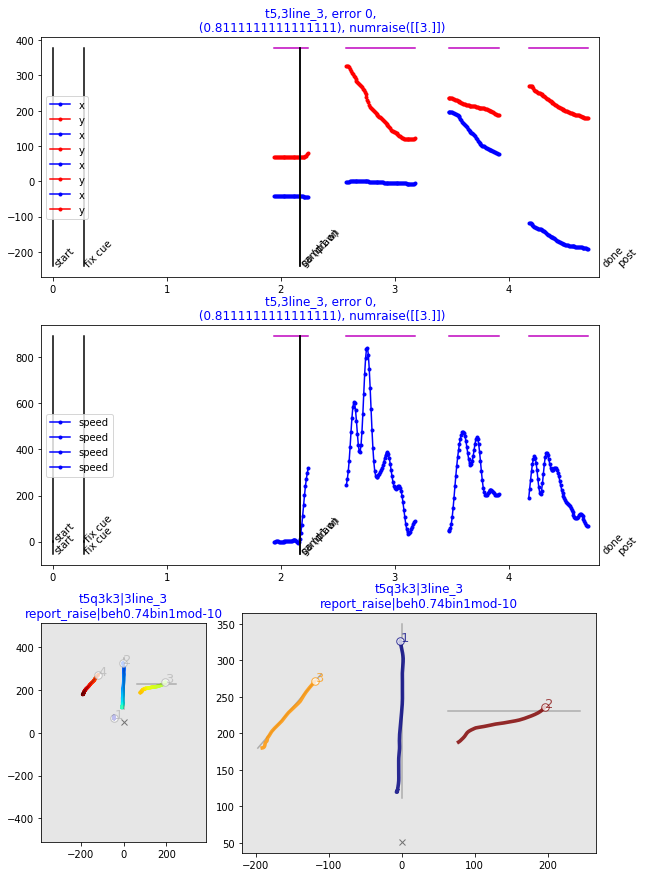

In [446]:
plotTrialSingleOverview(fd, t);
# plotTrialSimpleTimecourse(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"])
# plotTrialSimple(PROBEDAT[i]["filedata"], PROBEDAT[i]["trial"], zoom=True, plotver="order", kwargs={'each_stroke_separate': True})

In [436]:
## TEST COMPUTATION OF VELOCITY
# subsamples --> differentiation --> upsamples --> norms(to get speed)


%matplotlib inline
from pythonlib.tools.stroketools import diff5pt

# == compute velocity given x,y,t timeseries
# assumes already (i) interpolated and (ii) smoothed
strokes = getTrialsStrokesByPeanuts(fd, t)
sample_rate = fd["params"]["sample_rate"]
# get separate velocities for x and y.

from pythonlib.tools.stroketools import strokesVelocity
strokes_vel, strokes_speeds = strokesVelocity(strokes, fs=fs, ploton=False, do_pre_filter=True, )


for t in getIndsTrials(fd):
    if getTrialsFixationSuccess(fd,t):
        print(t)
        strokes = getTrialsStrokesByPeanuts(fd,t)
        strokesVelocity(strokes, fs=fs, do_pre_filter=False)

got 983 total trials
2
3
not enough data to filter - using smoothing instead, and adaptive windowsize
4
not enough data to filter - using smoothing instead, and adaptive windowsize
5
6
not enough data to filter - using smoothing instead, and adaptive windowsize
7
not enough data to filter - using smoothing instead, and adaptive windowsize
8
9
not enough data to filter - using smoothing instead, and adaptive windowsize
10
11
12
13
14
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize
16
17
18
19
20
not enough data to filter - using smoothing instead, and adaptive windowsize
21
not enough data to filter - using smoothing instead, and adaptive windowsize
22
not enough data to filter - using smoothing instead, and adaptive windowsize
23
24
25
not enough data to filter - using smoothing instead, and adaptive windowsize
26
27
28
29
not enough data to filter - using smoothing instead, and ad

285
287
288
not enough data to filter - using smoothing instead, and adaptive windowsize
289
not enough data to filter - using smoothing instead, and adaptive windowsize
290
not enough data to filter - using smoothing instead, and adaptive windowsize
291
not enough data to filter - using smoothing instead, and adaptive windowsize
292
293
not enough data to filter - using smoothing instead, and adaptive windowsize
294
295
296
297
not enough data to filter - using smoothing instead, and adaptive windowsize
skipping differnetiation, stroke too short. giving NAN
298
not enough data to filter - using smoothing instead, and adaptive windowsize
299
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough data to filter - using smoothing instead, and adaptive windowsize
300
301
not enough data to filter - using smoothing instead, and adaptive windowsize
302
303
304
305
306
307
not enough data to filter - using smoothing instead, and adaptive windowsize
not enough

not enough data to filter - using smoothing instead, and adaptive windowsize
790
791
792
not enough data to filter - using smoothing instead, and adaptive windowsize
793
794
797
798
799
801
802
803
943
944
945
946
not enough data to filter - using smoothing instead, and adaptive windowsize
947
948
949
950
954
964
965
966
967
not enough data to filter - using smoothing instead, and adaptive windowsize
970
971
972
975


In [294]:
## TEST COMPUTATION OF VELOCITY
# subsamples --> differentiation --> upsamples --> norms(to get speed)
if False:
    # THis is obsolete -old version trying diferent version of up/downsampling.

    %matplotlib inline
    from pythonlib.tools.stroketools import diff5pt

    if False:
        # FAKE DATA
        from math import sin, pi
        x = [sin(y) for y in np.linspace(0, 2*pi, 100)]
        # y = np.random.rand(10,1)

        v = diff5pt(x)

        plt.figure()
        plt.plot(np.linspace(0, 1, len(x)), x, '-ok')
        plt.figure()
        plt.plot(np.linspace(0, 1, len(x)), v, '-ob')


    # == compute velocity given x,y,t timeseries
    # assumes already (i) interpolated and (ii) smoothed
    strokes = getTrialsStrokesByPeanuts(fd, t)
    sample_rate = fd["params"]["sample_rate"]
    # get separate velocities for x and y.
    # get velocity by taking norm of x and y velocities.

    # 1) interpolate with spline (~100hz)

    # 2) filter at 20hz
    if False:
        # already doing this in preprocessing step
        strokes = smoothStrokes(strokes, sample_rate, window_time=0.075)
        print("TODO - replace with buttor")

    for strok in strokes:

        # 3) downsample to 40hz
        # TRY DIFFERNET VERSION OF DOWNSAMPLING BY SWITCHING True/False below (1,2,3)
        from scipy.signal import decimate
        fs_new = 30
        if False: # 1
            # just interpolating
            strok_down = strokesInterpolate2([strok], N=["fsnew", fs_new, sample_rate])[0]
        else:
            q = int(np.round(sample_rate/fs_new))
            strok_down = []
            for i in range(2):
                    if False: # 2
                        strok_down.append(decimate(strok[:,i], q=q))
                    else: # 3
                        # dont use, too choppy
                        from scipy.signal import resample
                        num = int(np.round(len(strok)/q))
    #                     num=int(np.round(len(strok)*10))
                        x, t= resample(strok[:,i], num=num, t = strok[:,2])
                        strok_down.append(x)
            t_down = np.linspace(strok[0,2], strok[-1,2], len(strok_down[0]))
            strok_down.append(t_down)
            strok_down = np.concatenate([s[:,None] for s in strok_down], axis=1)
        plt.figure()
        plt.title("subsampling")
    #     print(strok_down)
        for i in [0,1]:
            plt.plot(np.linspace(0,1, len(strok[:,i])), strok[:,i], '-ok');
            plt.plot(np.linspace(0,1, len(strok_down[:,i])), strok_down[:,i], '-or');


        # 3) differentiate
        # what is sample interval?
        a = np.diff(strok_down[:,2]).round(decimals=4)
        per = np.unique(a)
        print(per)
        assert len(per)==1, "why multiple periods?"

        # 4) compute velocities (x and y)
        strok_down_vels = []
        for i in [0,1]:
            xvel = diff5pt(strok_down[:,i], h=per)

    #         plt.figure()
    #         plt.plot(np.linspace(0, 1, len(strok_down[:,2])), strok_down[:,i], '-ok')
            plt.figure()
            plt.plot(np.linspace(0, 1, len(xvel)), xvel, '-ob')
            strok_down_vels.append(xvel)
        strok_down_vels.append(strok_down[:,2])
        strok_down_vels = np.concatenate([s[:,None] for s in strok_down_vels], axis=1)

        # 4) interpolate and upsample velocity
        # upsample back to original sample rate
        n = int(np.round((strok_down_vels[-1,2] - strok_down_vels[0,2])/(1/sample_rate)))
        strok_down_vels = strokesInterpolate([strok_down_vels], n)[0]
        plt.figure()
        plt.title("velocities")
        for i in [0,1]:
            plt.plot(np.linspace(0, 1, strok_down_vels.shape[0]), strok_down_vels[:,i], '-ob')

        strok_down_vels = smoothStrokes([strok_down_vels], sample_rate, window_time=0.075)[0]
        for i in [0,1]:
            plt.plot(np.linspace(0, 1, strok_down_vels.shape[0]), strok_down_vels[:,i], '-or')

        # 5) get speed (norm of vel)
        strok_down_speeds = np.linalg.norm(strok_down_vels[:,[0,1]], axis=1)
        plt.figure()
        plt.title("speed")
        plt.plot(np.linspace(0, 1, len(strok_down_speeds)), strok_down_speeds, '-om')



